# Trigger efficiency study

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import exists
from typing import Union, List
from hist import Hist
from hist.intervals import clopper_pearson_interval
import vector

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import hist
import mplhep as hep

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"


import sys

In [2]:

def check_selector(sample: str, selector: Union[str, List[str]]):
    if isinstance(selector, list) or isinstance(selector, tuple):     # If selector is a list or tuple
        
        for s in selector:     # Iterate over the list or tuple
            if s.startswith("*"):     # If selector starts with '*', check if the rest of the selector is in sample
                if s[1:] in sample:
                    return True
            else:
                if sample.startswith(s):
                    return True
    else:   # If selector is a single string
        if selector.startswith("*"):
            if selector[1:] in sample:
                return True
        else:
            if sample.startswith(selector):
                return True

    return False

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

#### Reading parquets for the samples

In [20]:
data_dir = "/Users/gbibim/Here/genZ"
#y = "2022"
y = "2023"
samples = {
    y: {
        "Zto2Q-4Jets": ["Zto2Q-4Jets_HT-400to600", "Zto2Q-4Jets_HT-600to800", "Zto2Q-4Jets_HT-800", "Zto2Q-4Jets_HT-200to400"],
        "Zto2Q-2Jets": ["Zto2Q-2Jets_PTQQ-100to200_1J", "Zto2Q-2Jets_PTQQ-200to400_1J", "Zto2Q-2Jets_PTQQ-400to600_1J", 
                        "Zto2Q-2Jets_PTQQ-600_1J", "Zto2Q-2Jets_PTQQ-100to200_2J", "Zto2Q-2Jets_PTQQ-200to400_2J", "Zto2Q-2Jets_PTQQ-400to600_2J", "Zto2Q-2Jets_PTQQ-600_2J" ],
        #"Zto2Nu-2Jets": ["Zto2Nu-2Jets_PTNuNu-200to400_1J", "Zto2Nu-2Jets_PTNuNu-400to600_1J", "Zto2Nu-2Jets_PTNuNu-600_1J", 
        #                 "Zto2Nu-2Jets_PTNuNu-200to400_2J", "Zto2Nu-2Jets_PTNuNu-400to600_2J", "Zto2Nu-2Jets_PTNuNu-600_2J"],
    },
}[y]  #This is a way to retrieve the dictionary for the year "2022" from the dictionary of samples

full_samples_list = listdir(f"{data_dir}/{y}/") # list of all samples in the directory

events_dict = {}


##### Loading the samples

In [21]:
for label, selector in samples.items():  #Iterating over the dictionary of samples. Label is the key and selector is the value associated with the key
    #label = Zto2Q-4Jets
    #selector = Zto2Q-4Jets_HT-400to600, Zto2Q-4Jets_HT-200to400, Zto2Q-4Jets_HT-600

    events_dict[label] = {}  # initiates an empty list for the label key in the events_dict dictionary
    print(selector)
    
    for sample in selector:
        events_dict[label][sample] = [] 
        if not check_selector(sample, selector):    # checks if the sample is in the selector list
            print(sample)
            continue
        if not exists(f"{data_dir}/{y}/{sample}/parquet"):    #checks if the parquet file exists
            print(f"No parquet file for {sample}")
            continue

        events = pd.read_parquet(f"{data_dir}/{y}/{sample}/parquet", columns=None)
        not_empty = len(events) > 0
        if not_empty:
            events_dict[label][sample] = events
        print(f"Loaded {sample: <50}: {len(events)} entries")


    # If there are any DataFrames for the current label, concatenate them
    #if events_dict[label]:
    #    all_events = pd.concat(events_dict[label].values(), ignore_index=True)
    #    events_dict[label]['all'] = all_events  # Store the concatenated DataFrame under a special key

    # If no data was loaded for the label, delete the entry
    if not events_dict[label]:
        del events_dict[label]




['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400']
Loaded Zto2Q-4Jets_HT-400to600                           : 3873904 entries
Loaded Zto2Q-4Jets_HT-600to800                           : 4111998 entries
Loaded Zto2Q-4Jets_HT-800                                : 4069506 entries
Loaded Zto2Q-4Jets_HT-200to400                           : 4273017 entries
['Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J']
Loaded Zto2Q-2Jets_PTQQ-100to200_1J                      : 18998967 entries
Loaded Zto2Q-2Jets_PTQQ-200to400_1J                      : 7929898 entries
Loaded Zto2Q-2Jets_PTQQ-400to600_1J                      : 971914 entries
Loaded Zto2Q-2Jets_PTQQ-600_1J                           : 1043033 entries
Loaded Zto2Q-2Jets_PTQQ-100to200_2J              

In [11]:
events

GenVEta   GenVPhi GenVMass GenVPt bbFatJetVMatch        ak8FatJetEta  \
               0         0        0      0              0      1            0   
0       0.578125  1.589844    91.00  682.0              0 -99999    -0.458435   
1      -0.204590  0.317383    89.75  610.0              0 -99999     0.123428   
2       1.367188 -2.234375    90.75  830.0              0 -99999     0.427002   
3      -0.589844 -0.401367   110.50  596.0              0 -99999    -0.779053   
4       0.748047 -2.843750    87.50  680.0              0 -99999     1.444336   
...          ...       ...      ...    ...            ...    ...          ...   
939149  0.327148  0.570312    92.50  730.0              0 -99999    -0.705811   
939150 -0.513672  1.648438    95.50  600.0              0 -99999    -0.182770   
939151  0.714844  1.472656    89.50  676.0              0      1     0.458008   
939152 -0.726562 -2.062500    96.00  600.0              0      0     0.146881   
939153 -0.679688 -2.367188    83.75  760.0              0      0     1.442871   

                     ak8FatJetPhi                ...  \
                   1            0             1  ...   
0      -99999.000000    -1.469971 -99999.000000  ...   
1      -99999.000000    -2.879883 -99999.000000  ...   
2      -99999.000000     0.899536 -99999.000000  ...   
3      -99999.000000     2.529297 -99999.000000  ...   
4      -99999.000000     0.266724 -99999.000000  ...   
...              ...          ...           ...  ...   
939149 -99999.000000    -2.640625 -99999.000000  ...   
939150 -99999.000000    -1.526611 -99999.000000  ...   
939151      0.646851    -1.699951      1.403320  ...   
939152     -1.710693     0.774780     -2.967285  ...   
939153     -0.227875     1.199463      0.434448  ...   

       VBF_DiPFJet80_45_Mjj650_PFMETNoMu85 VBF_DiPFJet110_35_Mjj650  \
                                         0                        0   
0                                    False                    False   
1                                    False                    False   
2                                    False                    False   
3                                    False                    False   
4                                    False                    False   
...                                    ...                      ...   
939149                               False                    False   
939150                               False                    False   
939151                               False                    False   
939152                               False                    False   
939153                               False                    False   

       VBF_DiPFJet110_35_Mjj650_TriplePFJet  \
                                          0   
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   
...                                     ...   
939149                                False   
939150                                False   
939151                                False   
939152                                False   
939153                                False   

       VBF_DiPFJet110_40_Mjj1000_Detajj3p5  \
                                         0   
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
939149                                   0   
939150                                   0   
939151                                   0   
939152                                   0   
939153                                   0   

       VBF_DiPFJet110_40_Mjj1000_Detajj3p5_TriplePFJet  \
                                 

In [12]:
events.columns


MultiIndex([(                                            'GenVEta', 0),
            (                                            'GenVPhi', 0),
            (                                           'GenVMass', 0),
            (                                             'GenVPt', 0),
            (                                     'bbFatJetVMatch', 0),
            (                                     'bbFatJetVMatch', 1),
            (                                       'ak8FatJetEta', 0),
            (                                       'ak8FatJetEta', 1),
            (                                       'ak8FatJetPhi', 0),
            (                                       'ak8FatJetPhi', 1),
            (                                      'ak8FatJetMass', 0),
            (                                      'ak8FatJetMass', 1),
            (                                        'ak8FatJetPt', 0),
            (                                        'ak8FatJetP

In [26]:
trigger_dict = {
    "HLTs": (
        [            
            # offline triggers
            "QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65",
            "PFHT1050",
            "AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35",
            #"AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35",
            #"AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35",
            "AK8PFJet230_SoftDropMass40",
            #"AK8PFJet425_SoftDropMass40",
            #"AK8PFJet400_SoftDropMass40",
            "AK8DiPFJet250_250_MassSD50",
            #"AK8DiPFJet260_260_MassSD30",
            #"AK8PFJet420_MassSD30",
            #"AK8PFJet230_SoftDropMass40_PNetBB0p06",
            #"AK8PFJet230_SoftDropMass40_PNetBB0p10",
            #"AK8PFJet250_SoftDropMass40_PNetBB0p06",
            
            # parking triggers
            
            # HHparking
            #"PFHT280_QuadPFJet30_PNet2BTagMean0p55",
            
            # VBFparking
            # https://its.cern.ch/jira/browse/CMSHLT-3058
            #"DiJet110_35_Mjj650_PFMET110",
            #"TripleJet110_35_35_Mjj650_PFMET110",
            #"VBF_DiPFJet80_45_Mjj650_PFMETNoMu85",
            #"VBF_DiPFJet110_35_Mjj650",
            #"VBF_DiPFJet110_35_Mjj650_TriplePFJet",
            #"VBF_DiPFJet110_40_Mjj1000_Detajj3p5",
            #"VBF_DiPFJet110_40_Mjj1000_Detajj3p5_TriplePFJet",
            #"VBF_DiJet_60_30_Mass500_DiJet50",
            #"VBF_DiJet_110_35_Mass620",
            
            # SingleMuonparking
            #"Mu12_IP6",
        ],
        "label",
    ),
    
}

In [16]:
events_dict.items()

dict_items([('Zto2Nu-2Jets', {'Zto2Nu-2Jets_PTNuNu-200to400_1J': [], 'Zto2Nu-2Jets_PTNuNu-400to600_1J': [], 'Zto2Nu-2Jets_PTNuNu-600_1J':          GenVEta   GenVPhi GenVMass GenVPt bbFatJetVMatch        ak8FatJetEta  \
               0         0        0      0              0      1            0   
0      -0.124023 -0.812500    91.75  948.0              0 -99999    -1.040771   
1       0.994141  1.890625    87.75  694.0              0 -99999    -0.881836   
2       0.232910  2.164062    95.50  650.0              0 -99999     0.779541   
3       1.171875 -0.697266    90.50  766.0              0 -99999    -0.524414   
4      -0.022949  0.116211    90.00  764.0              0 -99999    -1.252197   
...          ...       ...      ...    ...            ...    ...          ...   
926633 -2.359375 -0.708984    86.50  642.0              0 -99999     0.051834   
926634  0.416992 -0.051392    95.50  808.0              0 -99999    -0.410400   
926635 -0.488281 -1.472656    92.00  706.0          

#### Fill the histograms

In [27]:
import hist
import numpy as np

# Define histogram axes and initialize histograms
ht_bins_fine = (25, 200, 2000)
zpt_axis = hist.axis.Regular(100, 0, 1000, name="pt", label=r"Z pT$^0$ [GeV]")
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
sdm_axis = hist.axis.Regular(100, 0, 1000, name="SDm", label=r"SD mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)
process_axis = hist.axis.StrCategory([], name="process_name", growth=True)

hpt_fj = hist.Hist(fjpt_axis, cat_axis, sample_axis, process_axis)
hpt_z = hist.Hist(zpt_axis, cat_axis, sample_axis, process_axis)
hsd = hist.Hist(sdm_axis, cat_axis, sample_axis, process_axis)

use_default_weight = False    # If True, the weight is set to 1 for all events

# Fill histograms for each sample
for label, sample_dict in events_dict.items():
    for sample_name, events in sample_dict.items():
        pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm_fj = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        
        #selection = SDm_fj > 40   #40
        selection = pt_z > 150

        # Determine weight to use
        weight = 1 if use_default_weight else wd[selection]

        # Fill histograms for the sample
        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)
        hsd.fill(SDm=SDm_fj[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)

        # Fill histograms for stitched category
        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name=label, process_name=label, weight=weight)
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name=label, process_name=label, weight=weight)
        hsd.fill(SDm=SDm_fj[selection], cat="denominator", sample_name=label, process_name=label, weight=weight)

        # Fill histograms for each trigger category
  
        for trigger_title, (triggers, trigger_label) in trigger_dict.items():
            #trigger_selection = np.zeros_like(selection, dtype=bool)
            for hlt in triggers:
                trigger_selection = np.zeros_like(selection, dtype=bool)    # this has to be outside the loop if we want to apply multiple triggers at the same time
                trigger_selection |= (events[hlt].values == 1).squeeze()    #Use bitwise OR (|=) to update trigger_selection to True wherever any trigger condition is met.
                                                                            # squeeze() removes any single-dimensional entries from the shape of the array.
                num_selection = trigger_selection & selection

                weight = 1 if use_default_weight else wd[num_selection]

                hpt_fj.fill(pt=pt_fj[num_selection], cat=hlt, sample_name=sample_name, process_name=label, weight=weight)
                hpt_z.fill(pt=pt_z[num_selection], cat=hlt, sample_name=sample_name, process_name=label, weight=weight)
                hsd.fill(SDm=SDm_fj[num_selection], cat=hlt, sample_name=sample_name, process_name=label, weight=weight)
                
                hpt_fj.fill(pt=pt_fj[num_selection], cat=hlt, sample_name=label, process_name=label, weight=weight)
                hpt_z.fill(pt=pt_z[num_selection], cat=hlt, sample_name=label, process_name=label, weight=weight)
                hsd.fill(SDm=SDm_fj[num_selection], cat=hlt, sample_name=label, process_name=label, weight=weight)
                


In [26]:
events_dict['Zto2Q-2Jets']['Zto2Q-2Jets_PTQQ-100to200_1J']['QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65'].any()

0    False
dtype: bool8

In [18]:
has_true_values = events["AK8PFJet230_SoftDropMass40"].any()
print(has_true_values)

0    True
dtype: bool8


In [11]:
num_selection

0          False
1          False
2          False
3          False
4          False
           ...  
1023247    False
1023248    False
1023249    False
1023250    False
1023251    False
Name: 0, Length: 1023252, dtype: bool8

### Plots the denominators

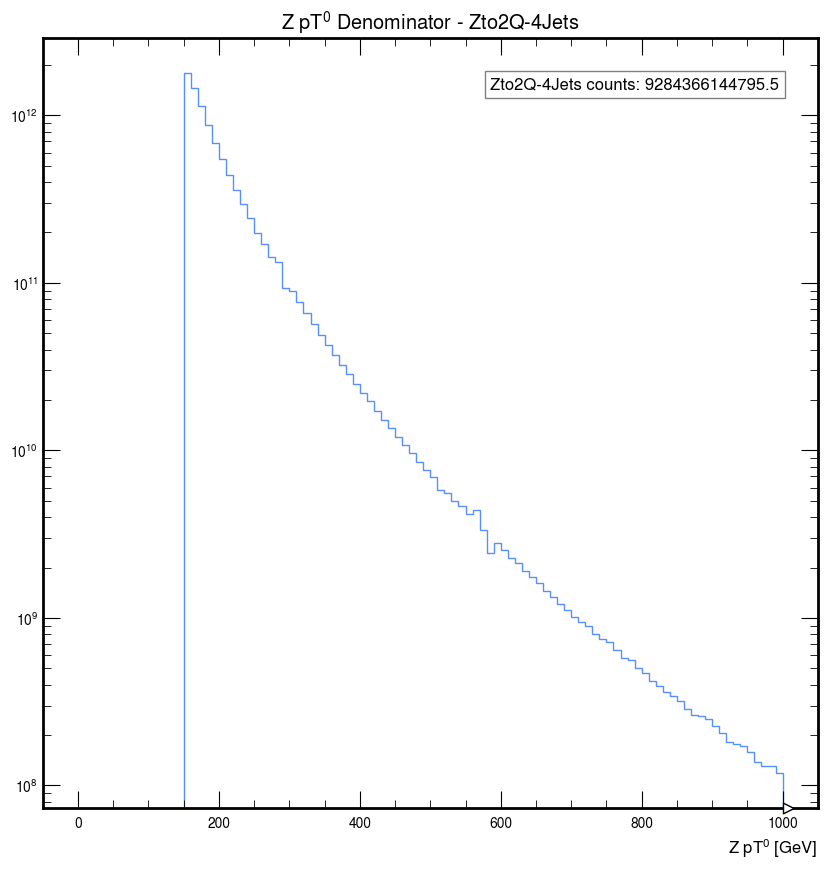

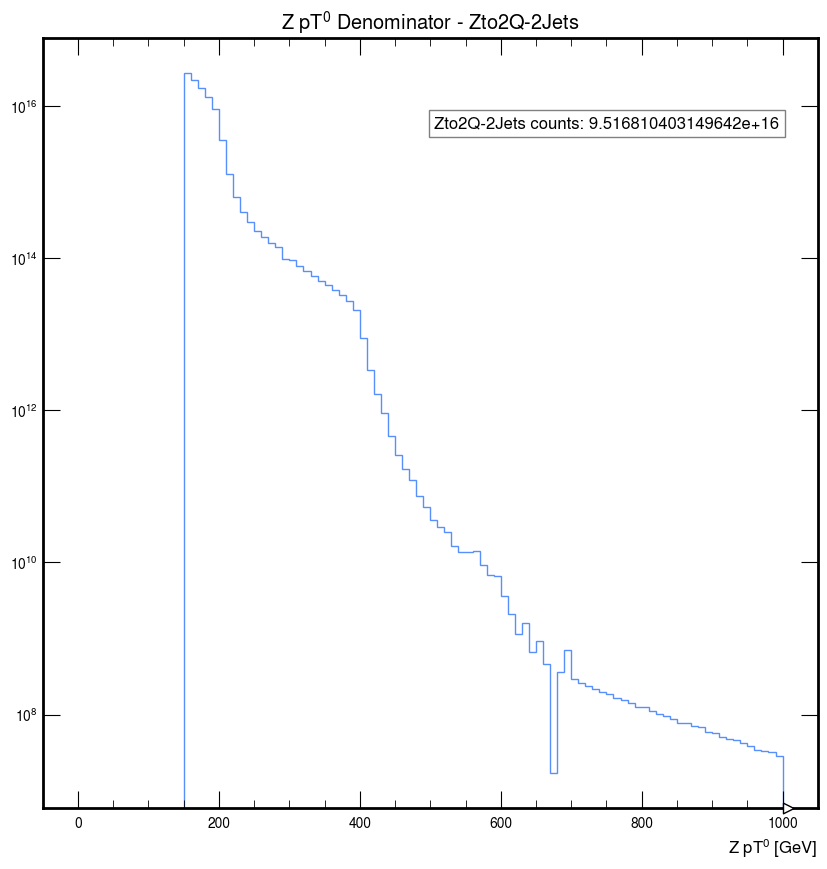

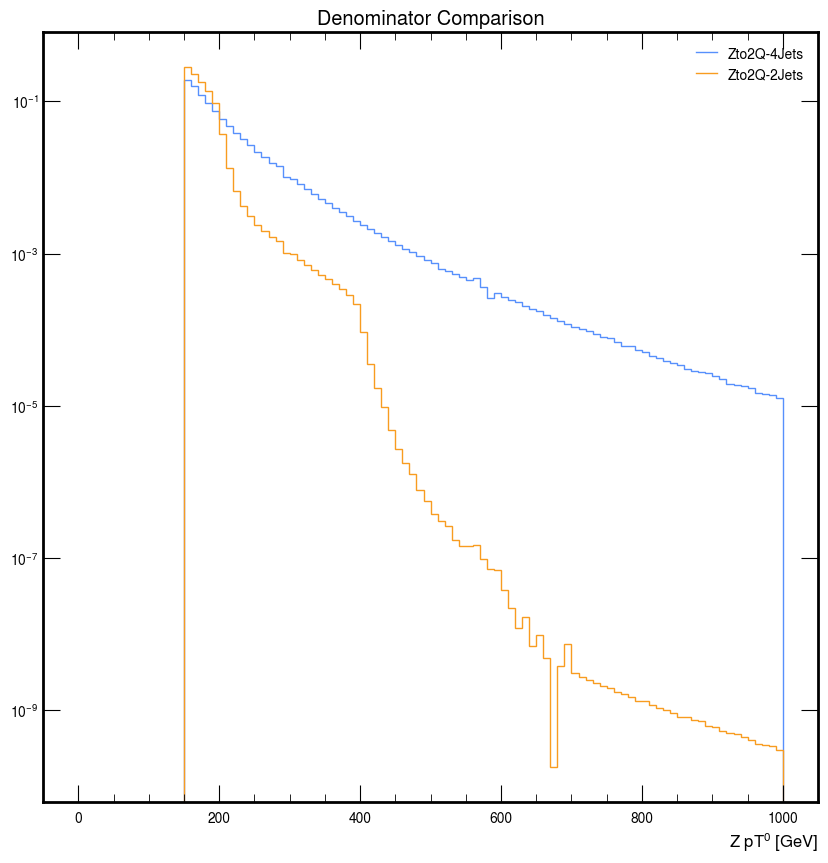

In [12]:
# Plot of the denominator comparing LO to NLO

for i, label in enumerate(samples):
    fig, ax = plt.subplots()
    h = hpt_z[{"cat": "denominator", "sample_name": label, "process_name": label}]
    hep.histplot(h, label=label)
    total_counts = sum(h.values())
    ax.set_yscale("log")    
    ax.text(0.95, 0.95 - i*0.05, f'{label} counts: {total_counts}', 
        ha='right', va='top', transform=ax.transAxes, 
        bbox=dict(facecolor='white', alpha=0.5))
    plt.title(f"Z pT$^0$ Denominator - {label}")
    
    plt.savefig(f"plots/{y}/{label}_denominator_withWeights.png")

# For the comparison plot
fig, ax = plt.subplots()
for label in samples:
    h = hpt_z[{"cat": "denominator", "sample_name": label, "process_name": label}]
    
    # Normalize histogram values to unit area
    total_counts = sum(h.values())
    h_normalized = h.values() / total_counts
    bin_edges = h.axes.edges[0]  # Assuming a single axis histogram
    
    # Plot the normalized histogram
    hep.histplot(h_normalized, bins=bin_edges, ax=ax, label=label)
    
ax.set_yscale("log")
ax.legend()
plt.title(f"Denominator Comparison")
plt.xlabel(r"Z pT$^0$ [GeV]")
plt.savefig(f"plots/{y}/Zpt_denominator_comparison_withWeights.png")

In [13]:
import matplotlib.pyplot as plt
import hist

def plot_den(hist_to_plot, output_dir, var):
    """
    Plot denominator histograms and save them to files.
    
    Args:
        hist_to_plot (dict): Dictionary of histograms to plot.
        output_dir (str): Directory where the plots will be saved.
        var (str): Variable name to include in the plot filenames.
    """
    for label, selector in samples.items():
        #label = Zto2Q-4Jets
        #selector = Zto2Q-4Jets_HT-400to600, Zto2Q-4Jets_HT-200to400, Zto2Q-4Jets_HT-600

        # Plot for each sample in selector
        fig, ax = plt.subplots()
        for i, sample in enumerate(selector):
            h = hist_to_plot[{"cat": "denominator", "sample_name": sample, "process_name": label}]
            hep.histplot(h, ax=ax, label=sample)
            #total_counts = sum(h.values())
            # Position the annotation based on the index to avoid overlap
            #ax.text(0.95, 0.95 - i*0.05, f'{sample} counts: {total_counts}', 
                    #ha='right', va='top', transform=ax.transAxes, 
                    #bbox=dict(facecolor='white', alpha=0.5))

        ax.set_yscale("log")
        ax.legend()
        plt.title(f"Denominator Histograms for {label}")
        plt.ylabel("Counts")
        plt.savefig(f"{output_dir}/{y}/{var}_denominator_{label}.png")  # Save the plot as a PNG file
        #plt.close(fig)  # Close the figure to free up memory

# Define the output directory where plots will be saved
output_dir = "plots"

# Create the output directory if it does not exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


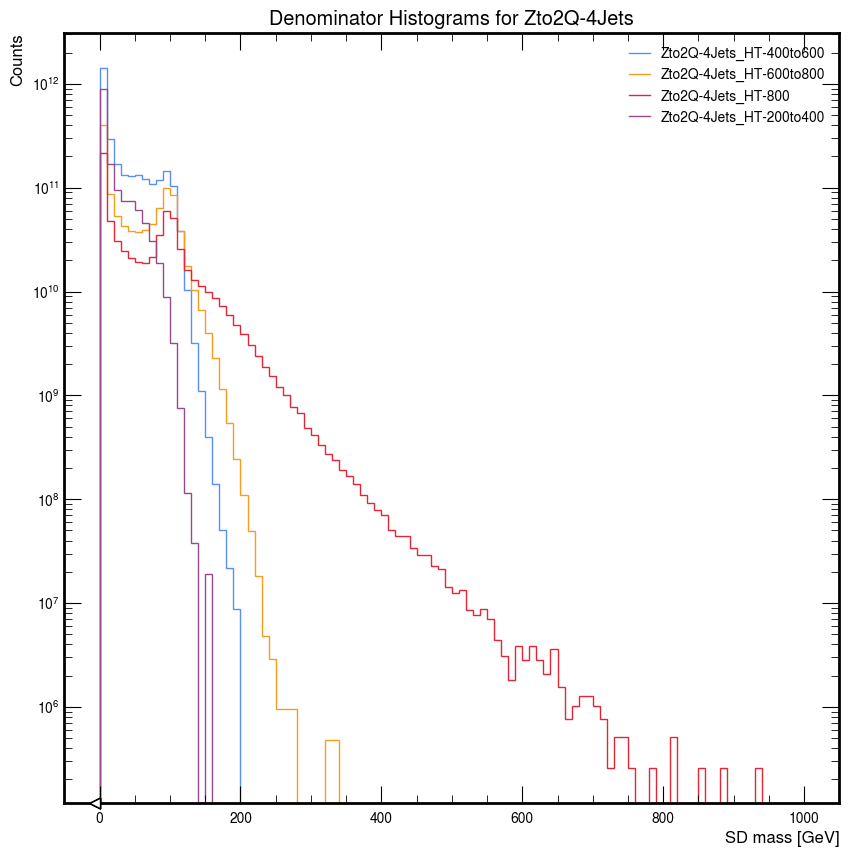

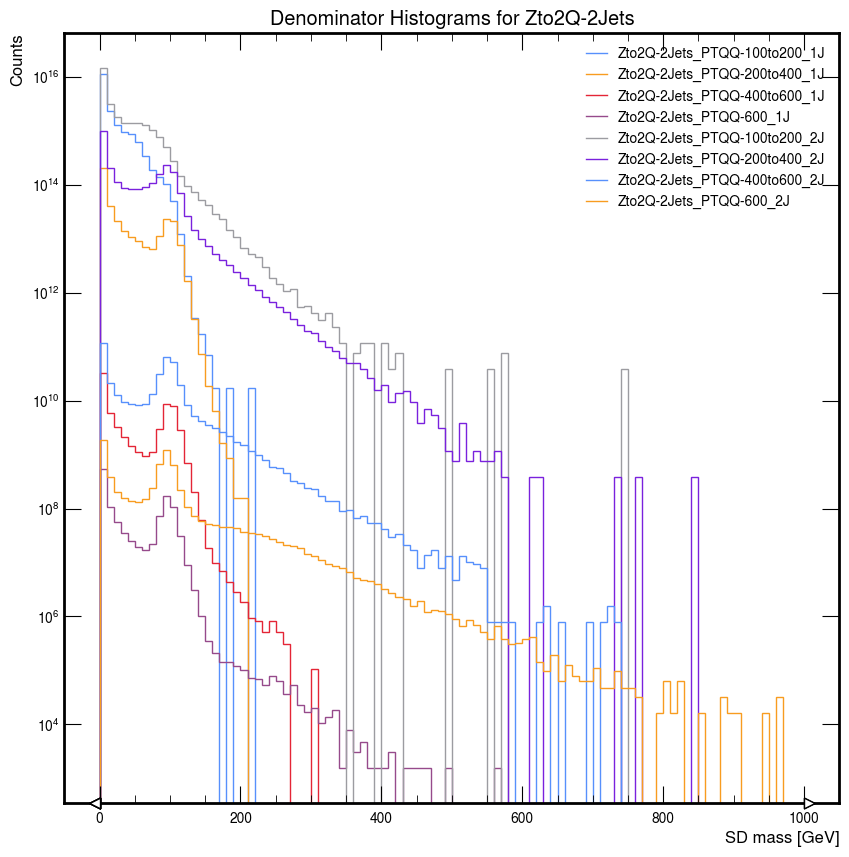

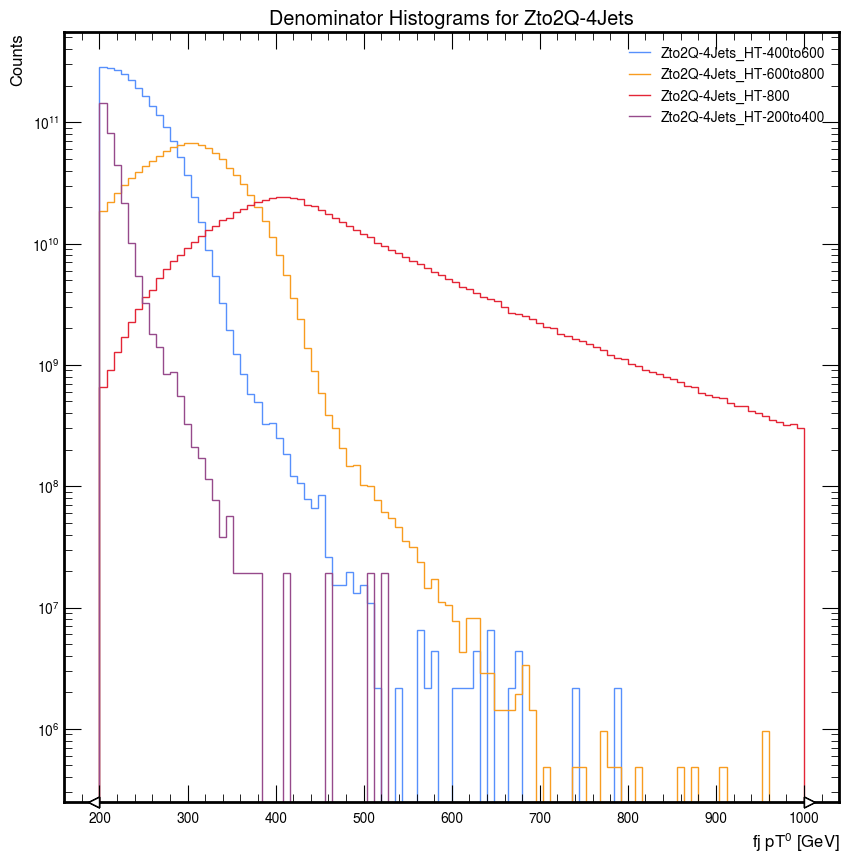

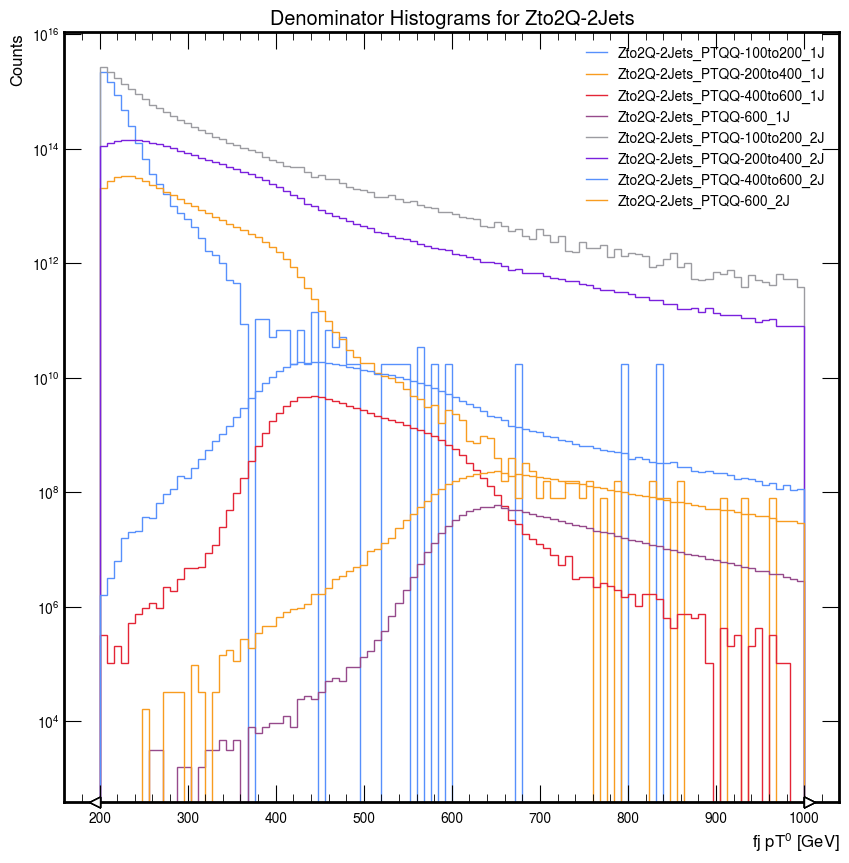

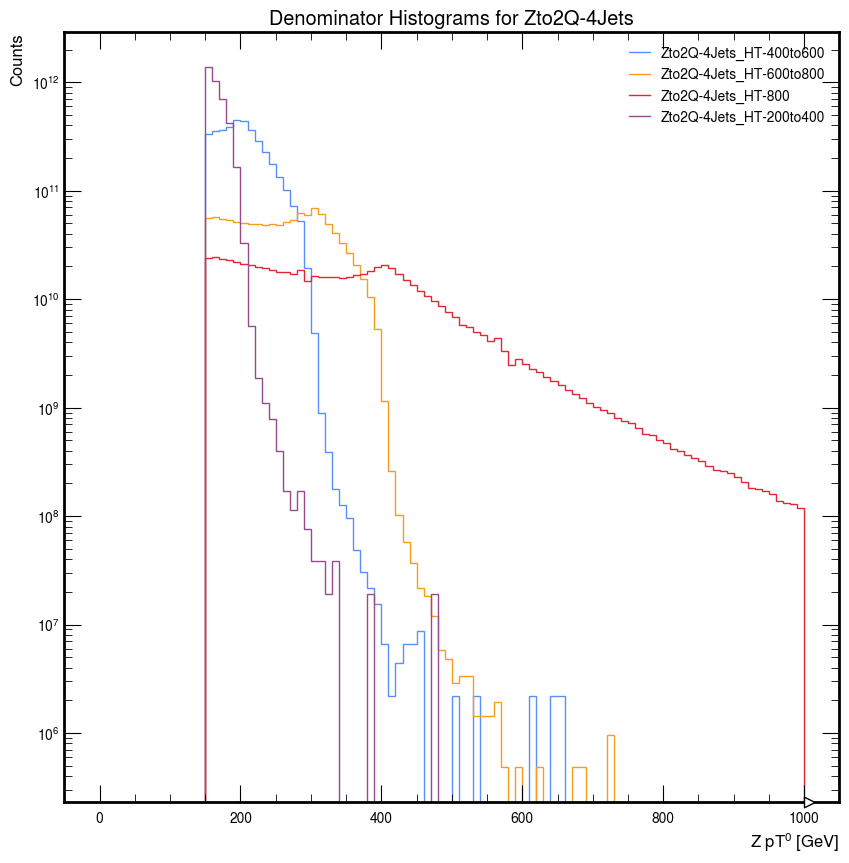

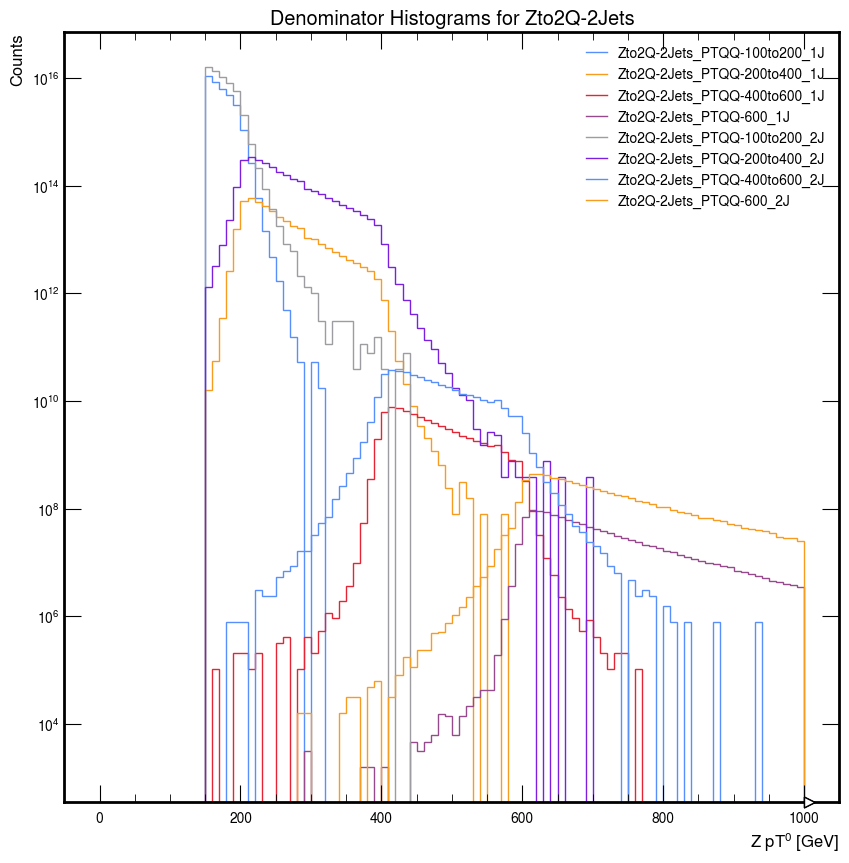

In [14]:
# Generate and save plots
plot_den(hsd, output_dir, var="SDm")
plot_den(hpt_fj, output_dir, var="fjpt")
plot_den(hpt_z, output_dir, var="zpt")


In [16]:
hpt_z

Hist(
  Regular(100, 0, 1000, name='pt', label='Z pT$^0$ [GeV]'),
  StrCategory(['denominator'], growth=True, name='cat'),
  StrCategory(['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400', 'Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J'], growth=True, name='sample_name'),
  StrCategory(['Zto2Q-4Jets', 'Zto2Q-2Jets'], growth=True, name='process_name'),
  storage=Double()) # Sum: 1.9035477679554048e+17 (1.903547812982665e+17 with flow)

#### Checking the triggers

QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65


KeyError: "'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not in axis"

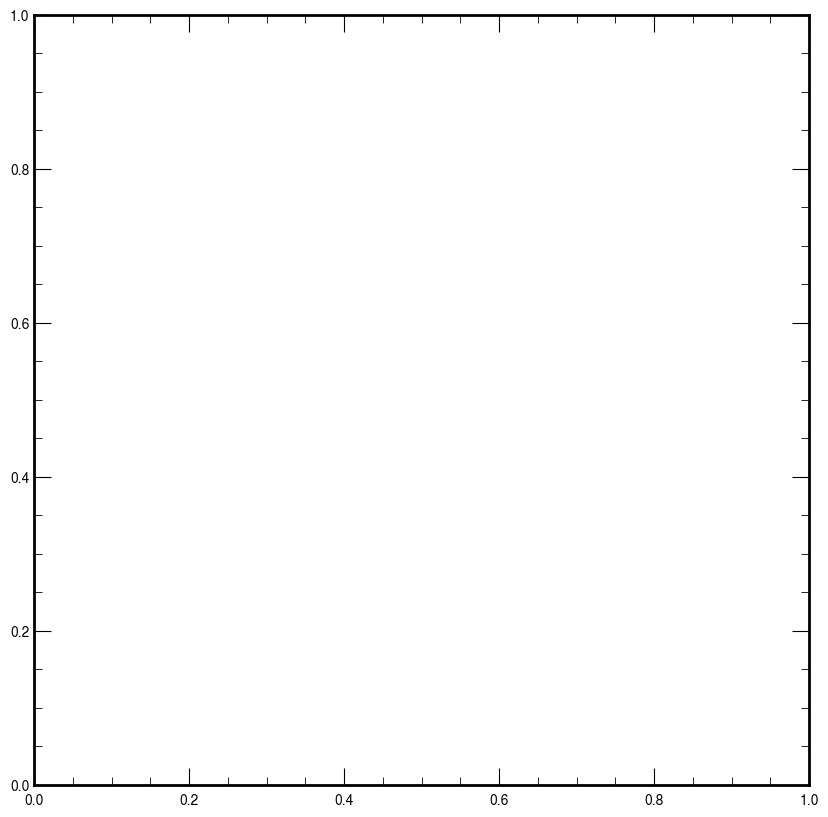

In [21]:
# comparing the triggers
sample = "Zto2Q-2Jets_PTQQ-100to200_2Js"
label = "Zto2Q-2Jets"
fig, ax = plt.subplots()    
for trigger_title, (triggers, trigger_label) in trigger_dict.items():
    for hlt in triggers:
        print(hlt)
        hep.histplot(hpt_z[{"cat": hlt, "sample_name": sample, "process_name": label}], ax=ax, label=hlt)
    #hep.histplot(hpt_z[{"cat": trigger_title, "sample_name": "Zto2Q-2Jets", "process_name": "Zto2Q-2Jets"}], ax=ax, label=trigger_title)

ax.legend()

### Efficiency

In [63]:
import matplotlib.pyplot as plt

def plot_eff(hist_to_plot, sample, sample_label, output_dir, var):
    """
    Plot triggers efficiency histograms and save them to files.
    
    Args:
        hist_to_plot (dict): Dictionary of histograms to plot.
        sample (str): Sample name.  ie. "Zto2Q-4Jets_HT-400to600"
        sample_label (str): Label for the sample. ie. "Zto2Q-4Jets"
        output_dir (str): Directory where the plots will be saved.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))   #efficiency plot

    for trigger_title, (triggers, trigger_label) in trigger_dict.items():
        for hlt in triggers:
            den_key = {"cat": "denominator", "sample_name": sample, "process_name": sample_label}
            num_key = {"cat": hlt, "sample_name": sample, "process_name": sample_label}
            
            try:
                den = hist_to_plot[{"cat": "denominator", "sample_name": sample, "process_name": sample_label}]
                num = hist_to_plot[{"cat": hlt, "sample_name": sample, "process_name": sample_label}]
                
                if num is None or den is None:
                    continue  # Skip if num or den is None

                num_view = num.view()
                den_view = den.view()


                with np.errstate(divide='ignore', invalid='ignore'):
                    ratio = np.divide(num_view, den_view)#, where=den_view!=0)

                #print(f"Ratio for {hlt}: {ratio}")

                hep.histplot(
                    #num/den,
                    ratio,
                    #yerr=abs((clopper_pearson_interval(num_view, den_view) - num_view) / den_view),
                    label=hlt,
                    ax=ax,
                    flow="none",
                )
            except KeyError:
                print(f"KeyError: '{hlt}' not found in the histogram dictionary.")
                continue
            
    ax.legend()

    ax.set_ylabel("Signal Trig. Eff.")
    ax.set_ylim(0, 1)
    ax.set_xlabel(var)
    plt.title(f"Signal Trigger Efficiency for {sample}")
    
    # Save the plot
    plt.savefig(f"{output_dir}/{y}/{var}_signal_trigger_efficiency_{sample}.png")
    #plt.close(fig)

# Define the output directory where plots will be saved
output_dir = "plots"

# Create the output directory if it does not exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



In [37]:
for axis in hpt_z.axes:
    print(f"Axis: {axis}")

Axis: Regular(100, 0, 1000, name='pt', label='Z pT$^0$ [GeV]')
Axis: StrCategory(['denominator', 'PFHT1050', 'AK8PFJet230_SoftDropMass40', 'AK8DiPFJet250_250_MassSD50'], growth=True, name='cat')
Axis: StrCategory(['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400', 'Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J'], growth=True, name='sample_name')
Axis: StrCategory(['Zto2Q-4Jets', 'Zto2Q-2Jets'], growth=True, name='process_name')


KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the hi

/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_77591/719020197.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))   #efficiency plot


KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the histogram dictionary.
KeyError: 'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65' not found in the histogram dictionary.
KeyError: 'AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35' not found in the hi

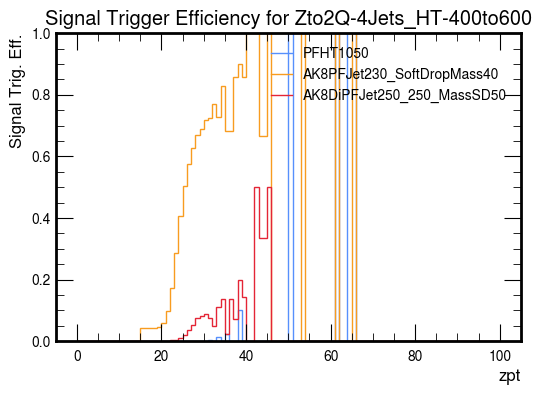

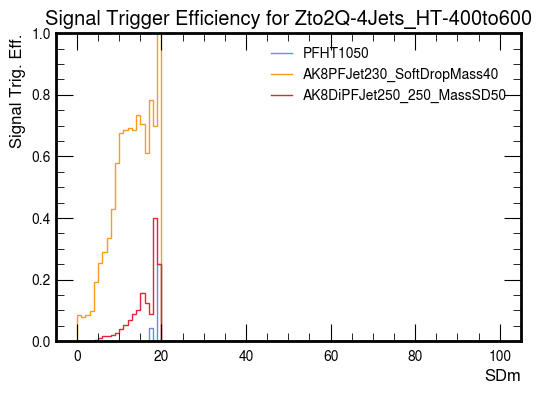

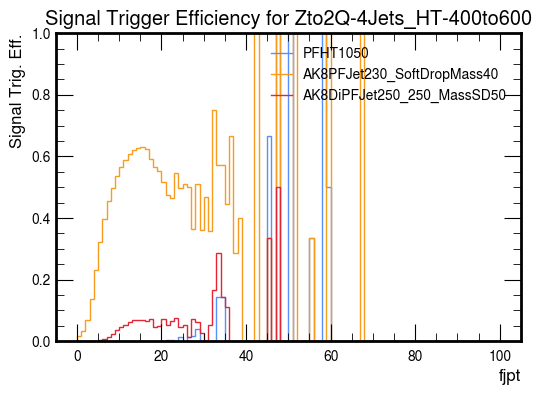

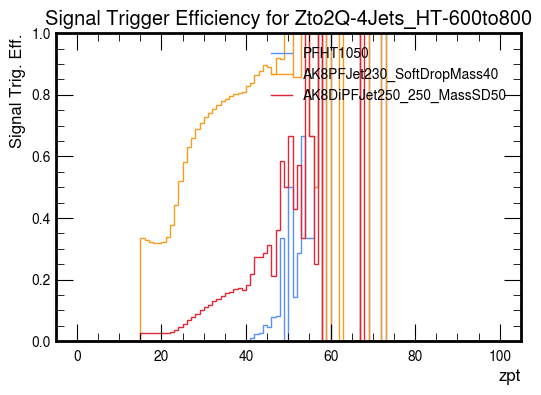

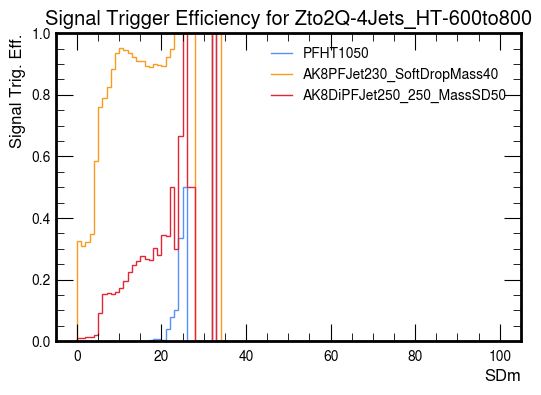

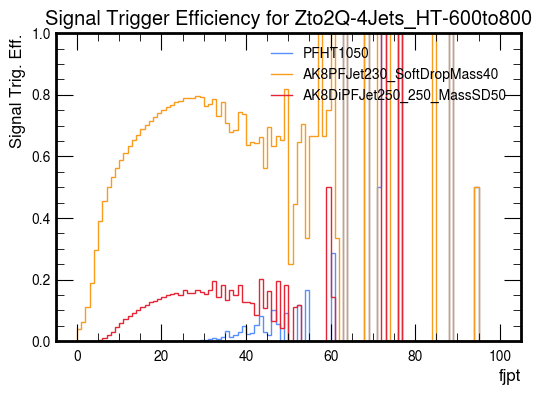

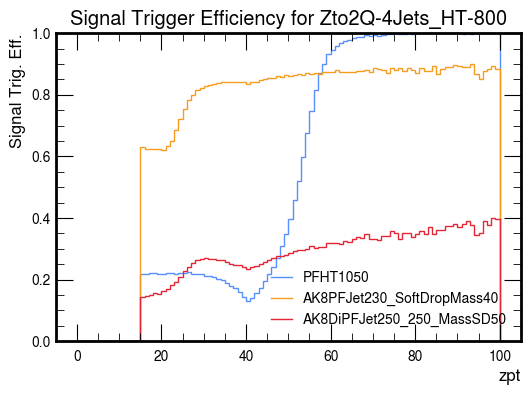

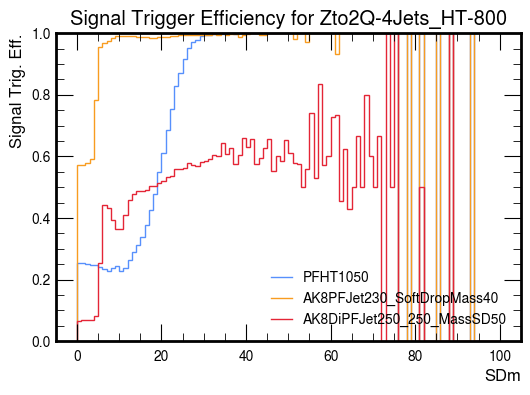

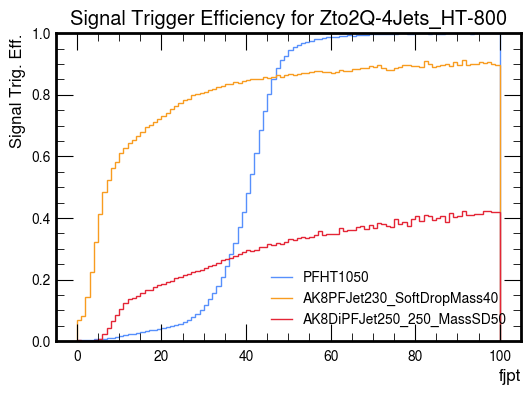

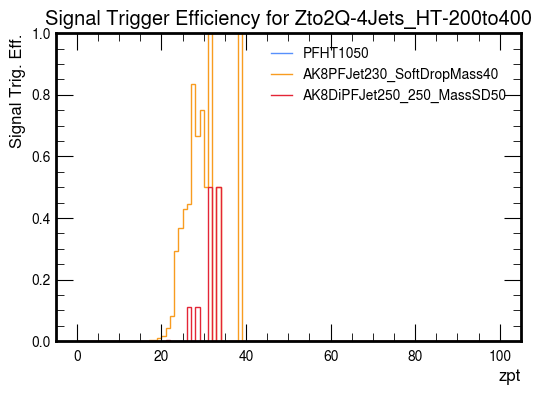

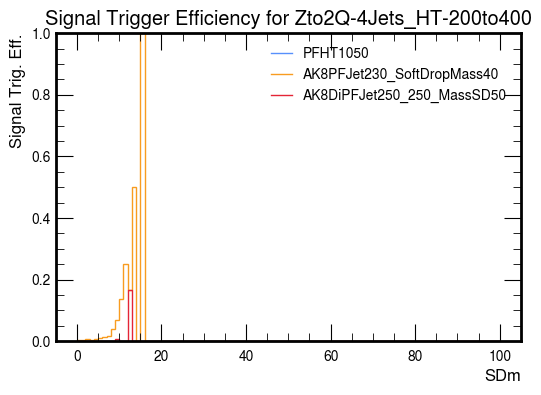

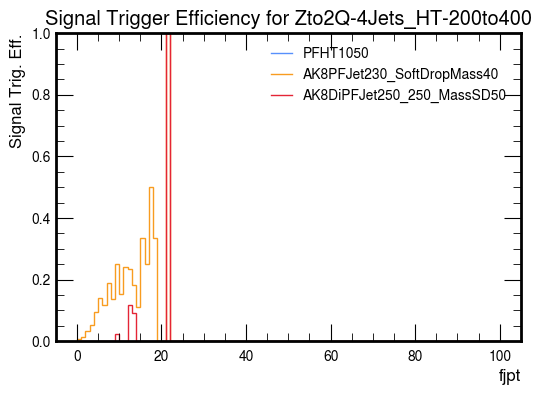

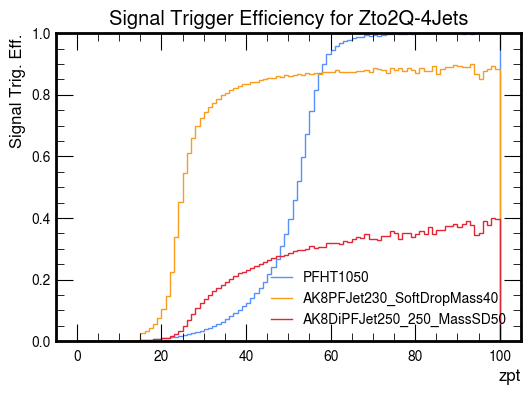

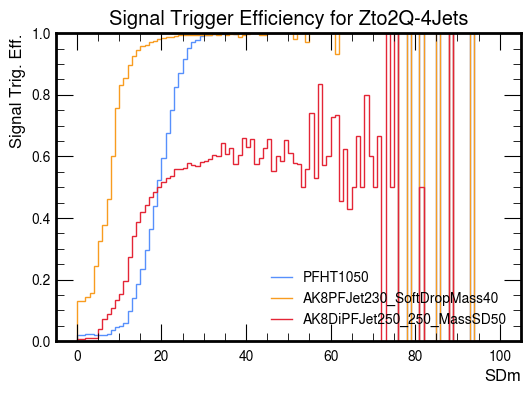

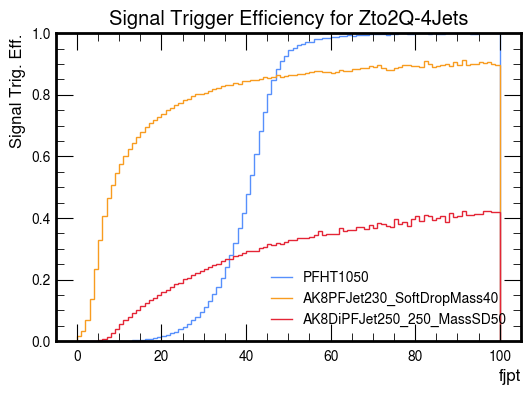

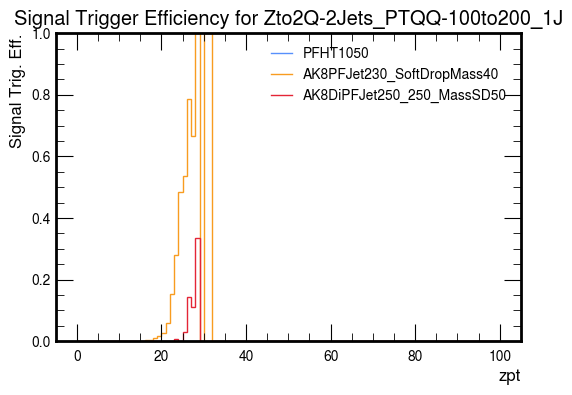

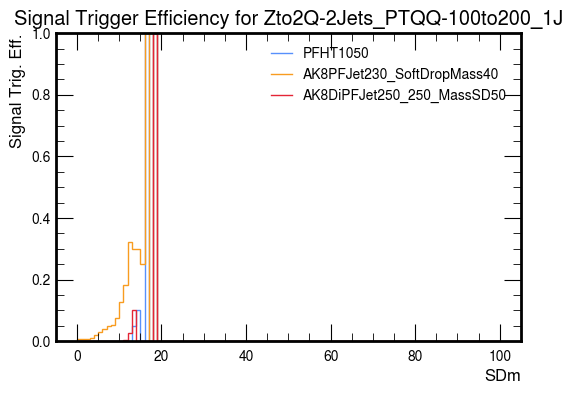

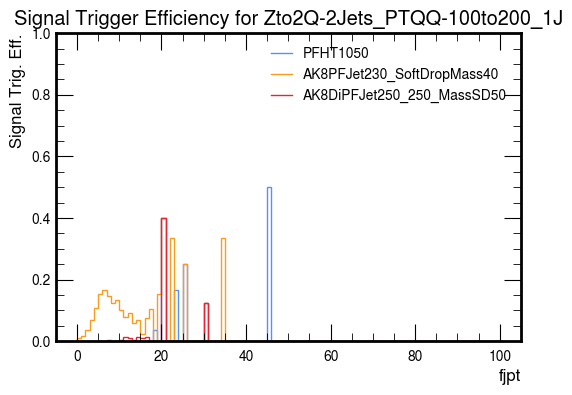

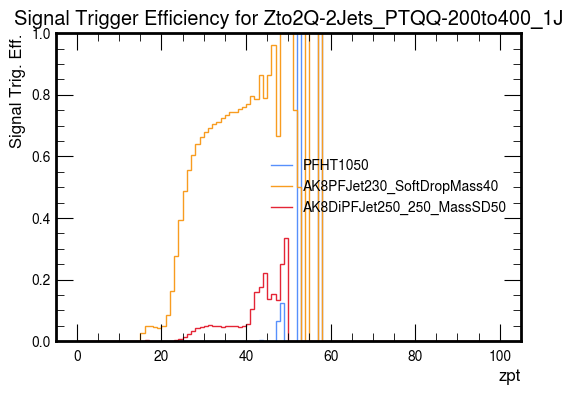

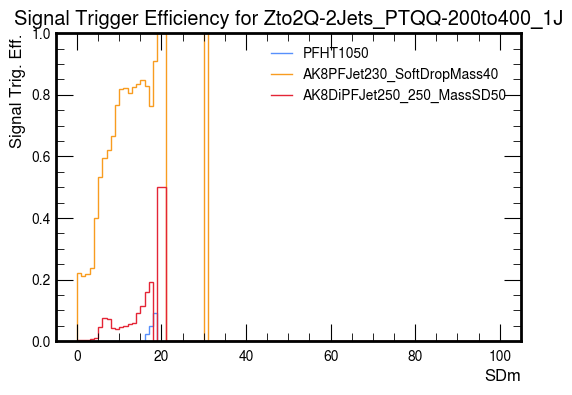

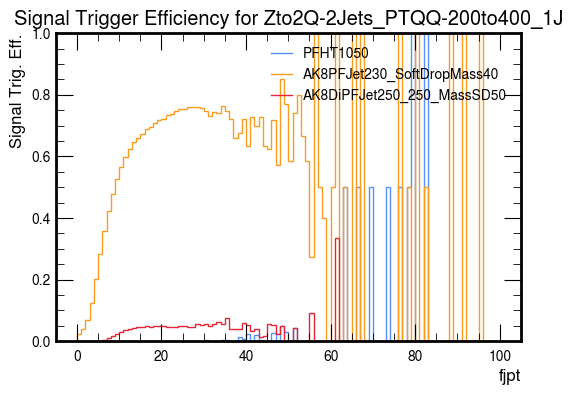

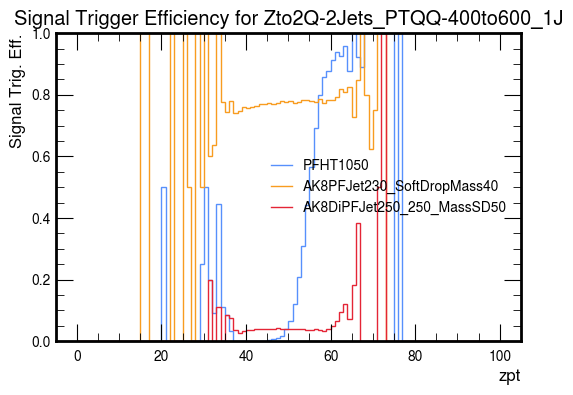

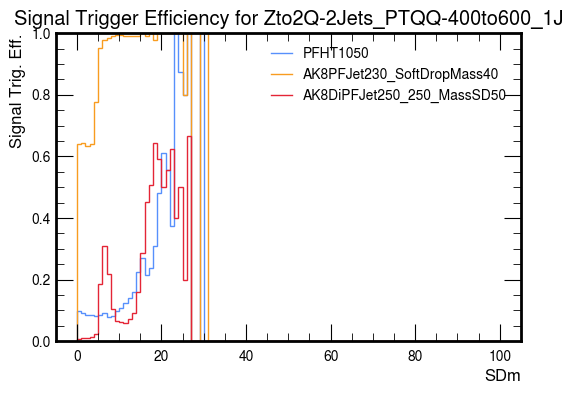

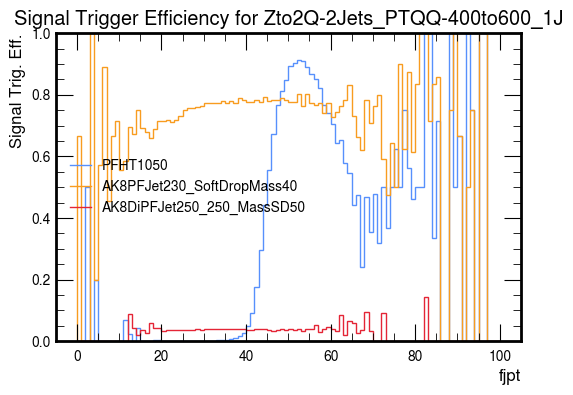

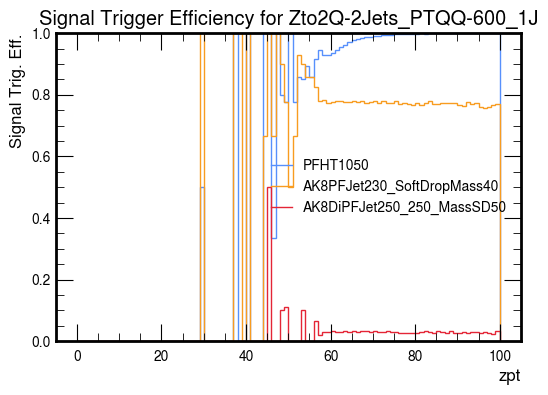

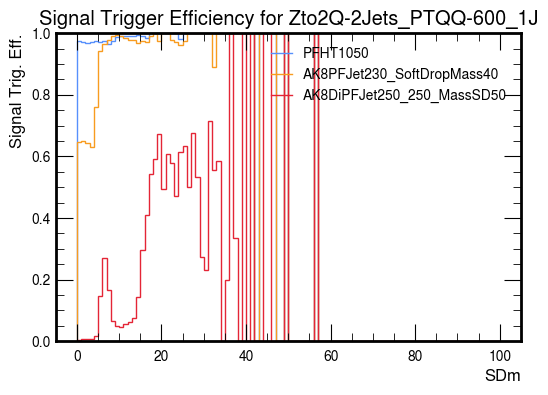

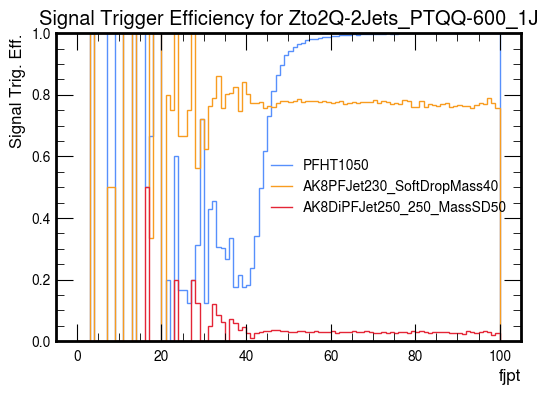

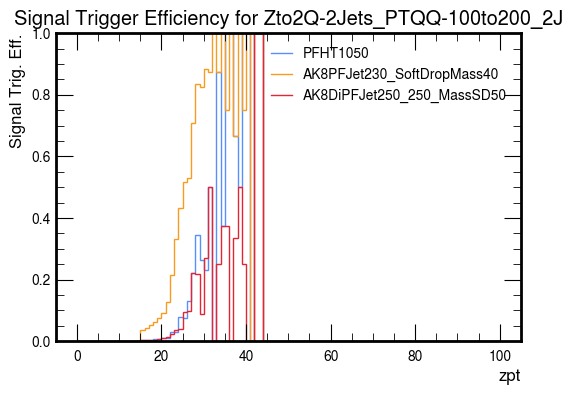

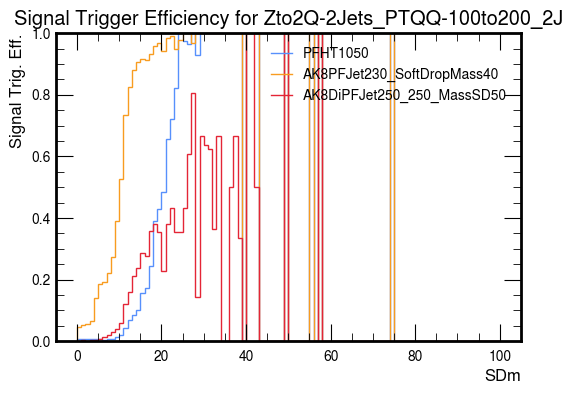

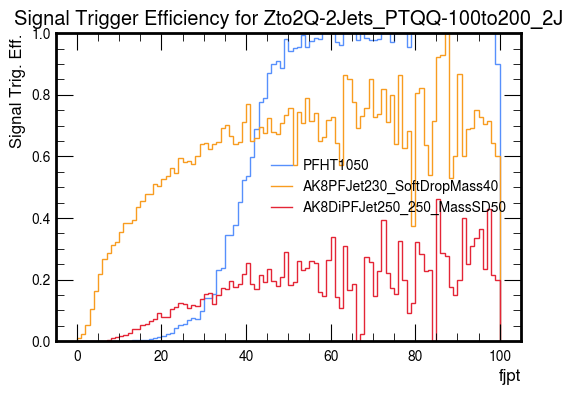

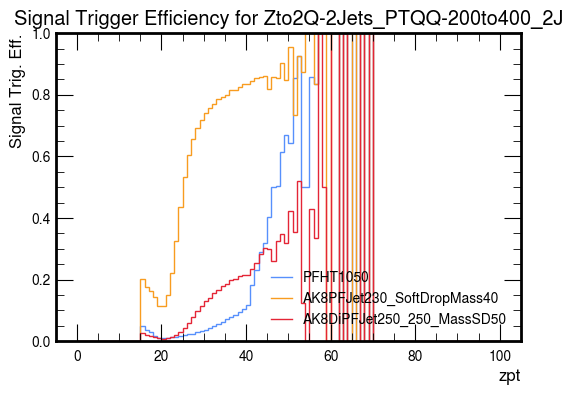

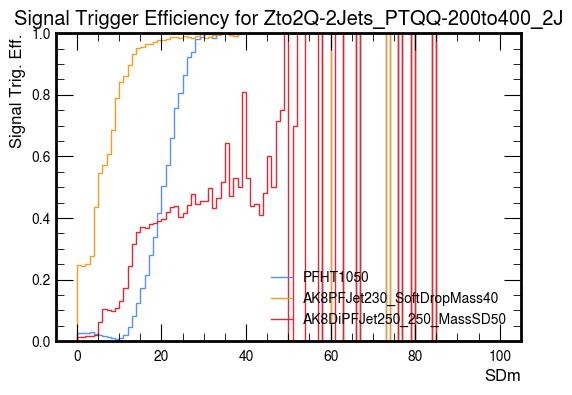

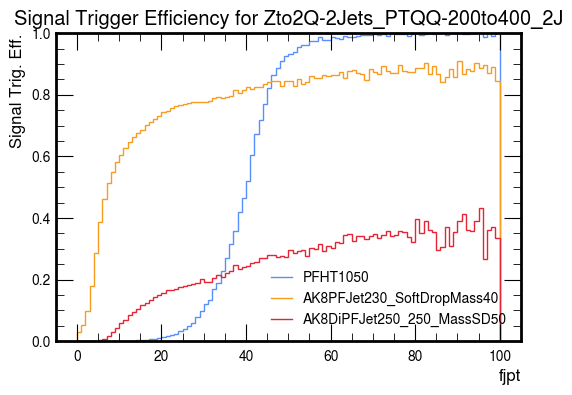

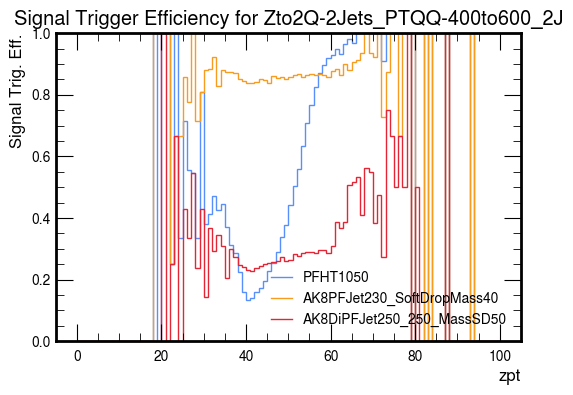

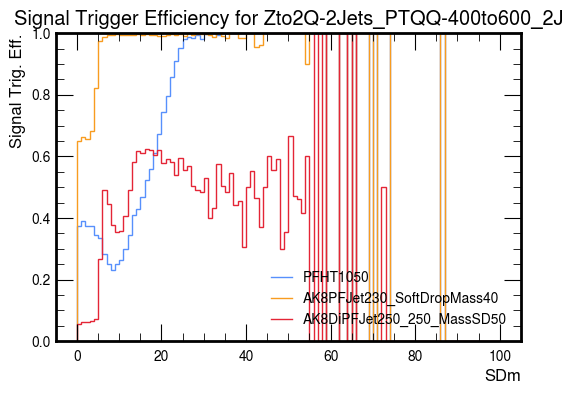

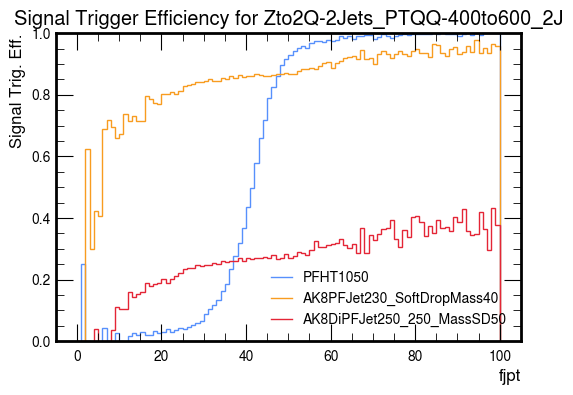

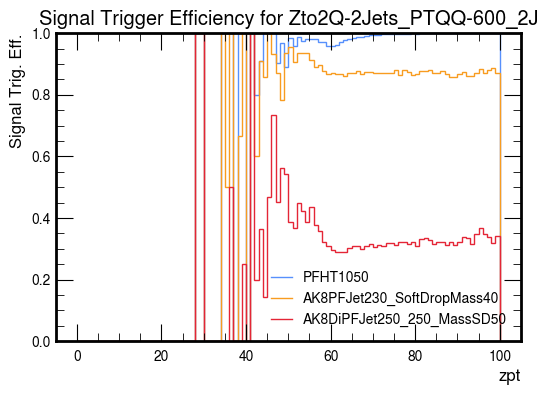

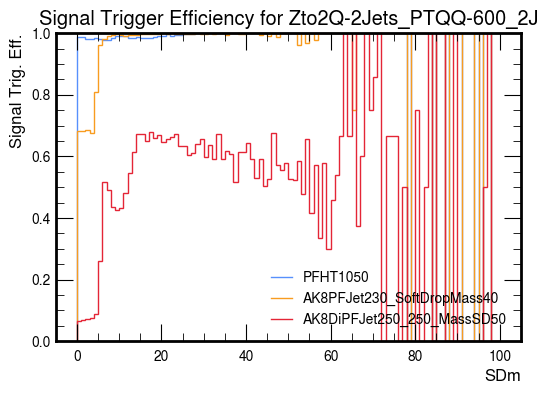

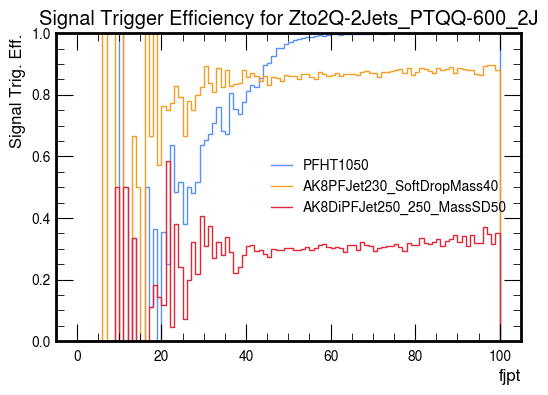

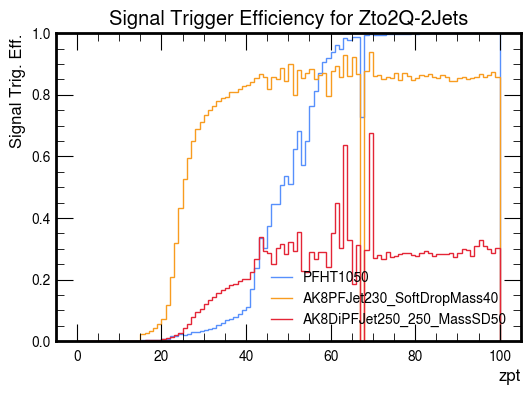

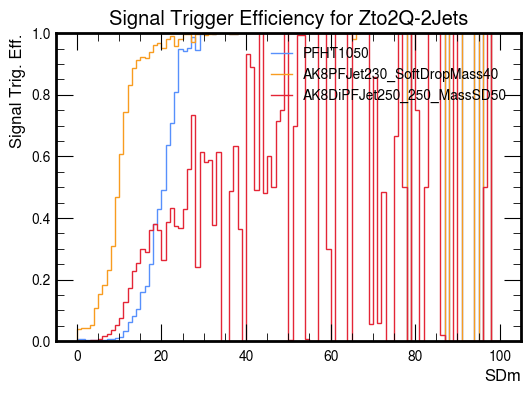

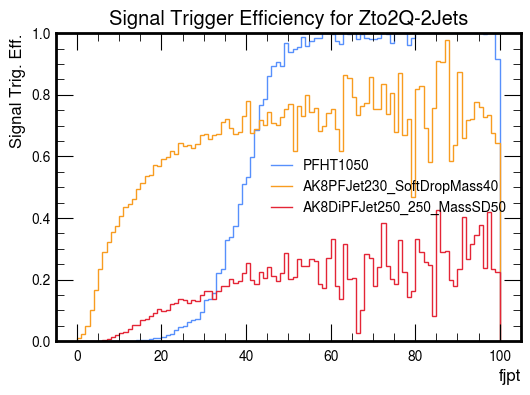

In [62]:
# Generate and save plots

for label, selector in samples.items():
    for sample in selector:
        plot_eff(hpt_z, sample, label, output_dir, var="zpt")
        plot_eff(hsd, sample, label, output_dir, var="SDm")
        plot_eff(hpt_fj, sample, label, output_dir, var="fjpt")

    plot_eff(hpt_z, label, label, output_dir, var="zpt")
    plot_eff(hsd, label, label, output_dir, var="SDm")
    plot_eff(hpt_fj, label, label, output_dir, var="fjpt")

### 2D hist of FatJetPt and SoftDropMass


In [ ]:
import hist
import matplotlib.pyplot as plt
import numpy as np

# Define the axes
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
SDm_axis = hist.axis.Regular(100, 0, 300, name="SDm", label="Soft Drop Mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)

# Create the histogram
h2d = hist.Hist(fjpt_axis, SDm_axis, cat_axis, sample_axis)

In [ ]:
# Filling the histogram

for label, sample_dict in events_dict.items():
    for sample_name, events in sample_dict.items():
        #pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm_fj = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        
        selection = SDm_fj > 40

        # For separated samples
        #h2d.fill(pt=pt_0[selection], cat="denominator", sample_name=sample, weight=wd[selection])
        #h2d.fill(pt=pt_0, SDm=SDm_0 cat="denominator", sample_name=sample) #no weight or cuts

        #for all samples
        h2d.fill(pt=pt_fj, SDm=SDm_fj, cat="denominator", sample_name=label, weight=wd) #no weight or cuts
        for trigger_title, (triggers, trigger_label) in trigger_dict.items():
            trigger_selection = np.zeros_like(selection)
            for hlt in triggers:
                trigger_selection |= (events[hlt].values == 1).squeeze()
            num_selection = trigger_selection
            #hpt.fill(pt=pt_0[num_selection & selection], cat=trigger_title, sample_name=sample, weight=wd[num_selection & selection])
            #hpt.fill(pt=pt_0[num_selection & selection], cat=trigger_title, sample_name="todas", weight=wd[num_selection & selection])

            #h2d.fill(pt=pt_0[num_selection], SDm=SDm_0[num_selection], cat=trigger_title, sample_name=sample)
            h2d.fill(pt=pt_fj[num_selection], SDm=SDm_fj[num_selection], cat=trigger_title, sample_name=label, weight=wd[num_selection])


In [ ]:
# Plot the 2D histogram
for label, selector in samples.items():
    fig, ax = plt.subplots()
    hep.hist2dplot(h2d[{"cat": "denominator", "sample_name": label}], ax=ax)
    #ax.set_xlabel("X-axis Label [units]")
    #ax.set_ylabel("Y-axis Label [units]")
    plt.title(f"FatJet pt vs. SoftDrop mass from {label}")


    plt.savefig(f"{output_dir}/fjpt_vs_SDM_{label}_withWeight_noselection_notrigger.png")
    plt.show()


In [ ]:
for label, selector in samples.items():
    fig, ax = plt.subplots()#1, 1, figsize=(6, 4))
    for trigger_title, (triggers, trigger_label) in trigger_dict.items():
        hep.hist2dplot(h2d[{"cat": trigger_title, "sample_name": label}], ax=ax, flow="none")
        ax.legend()
    #leg = ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title(f"FatJet pt vs. SofrDrop mass from {label}")

    # Save the plot
    plt.savefig(f"{output_dir}/fjpt_vs_SDm_{label}_withWeight_noselection_withtrigger.png")
    #plt.close(fig)